# Transformación previa al modelado

- Importo las librerías

In [1]:
import pandas as pd

- Cargo el dataset limpio de Tierra del Fuego (uso el separador ";")

In [2]:
df_tdf = pd.read_csv('../data/processed/dataset_tdf_limpio.csv', sep=";")

- Convierto el dataset de formato ancho a formato largo, dejando "Tipo de Delito" como columna fija.

In [3]:
df_tdf_largo = pd.melt(
    df_tdf,
    id_vars=['Tipo de Delito'],
    var_name='mes_anio_original',
    value_name='cantidad'
)

- Renombro la columna de tipo de delito

In [4]:
df_tdf_largo.rename(columns={'Tipo de Delito': 'tipo_delito'}, inplace=True)


- Separo la columna que contiene mes y año juntos en dos columnas distintas

In [5]:
df_tdf_largo[['mes_txt', 'anio']] = df_tdf_largo['mes_anio_original'].str.split(' ', expand=True)


- Creo un diccionario para convertir el nombre de los meses a números

In [6]:
meses_a_num = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6,
    'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10,
    'noviembre': 11, 'diciembre': 12
}
df_tdf_largo['mes'] = df_tdf_largo['mes_txt'].map(meses_a_num)

- Convierto el año y cantidad a números. Relleno los valores faltantes con 0

In [7]:
df_tdf_largo['anio'] = df_tdf_largo['anio'].astype(int)
df_tdf_largo['cantidad'] = pd.to_numeric(df_tdf_largo['cantidad'], errors='coerce').fillna(0).astype(int)


- Genero una nueva columna de texto con el formato mes-año

In [8]:
meses_nombre = {
    1: 'enero', 2: 'febrero', 3: 'marzo', 4: 'abril', 5: 'mayo', 6: 'junio',
    7: 'julio', 8: 'agosto', 9: 'septiembre', 10: 'octubre',
    11: 'noviembre', 12: 'diciembre'
}
df_tdf_largo['mes_anio_texto'] = df_tdf_largo['mes'].map(meses_nombre) + ' ' + df_tdf_largo['anio'].astype(str)


- Creo un identificador año-mes 

In [9]:
df_tdf_largo['mes_anio_simple'] = df_tdf_largo['anio'].astype(str) + '-' + df_tdf_largo['mes'].astype(str).str.zfill(2)


- Muestro las primeras filas para verificar la nueva estructura

In [10]:
print(df_tdf_largo[['tipo_delito', 'cantidad', 'mes_anio_texto', 'mes_anio_simple']].head())


                                       tipo_delito  cantidad mes_anio_texto  \
0                         Total Hechos delictuosos       453     enero 2014   
1                              Contra las Personas        60     enero 2014   
2                               Homicidios Dolosos         1     enero 2014   
3         Homicidios dolosos en grado de tentativa         0     enero 2014   
4     Homicidios Culposos e Accidentes de Tránsito         0     enero 2014   

  mes_anio_simple  
0         2014-01  
1         2014-01  
2         2014-01  
3         2014-01  
4         2014-01  


# Objetivo Nº1: Clasificar cada mes como "alto", "medio" o "bajo" en relación con el riesgo de delitos.
### Creación de la etiqueta "nivel_riesgo" para clasificar cada mes como bajo, medio o alto según la cantidad de delitos ocurridos en ese mes 

- Elimino columnas innecesarias si es que están presentes, ignoro los errores si no existen

In [11]:
df_tdf_largo = df_tdf_largo.drop(columns=['nivel_riesgo', 'cantidad_total'], errors='ignore')


- Agrupo por año y mes para obtener la cantidad total de delitos por un determinado periodo

In [12]:
delitos_por_mes = df_tdf_largo.groupby(['anio', 'mes'])['cantidad'].sum().reset_index()
delitos_por_mes.rename(columns={'cantidad': 'cantidad_total'}, inplace=True)


- Clasifico el total de delitos mensuales en niveles de riesgo bajo, medio o alto usando cuantiles

In [13]:
delitos_por_mes['nivel_riesgo'] = pd.qcut(
    delitos_por_mes['cantidad_total'],
    q=3,
    labels=['bajo', 'medio', 'alto']
)


- Uno la información de nivel de riesgo y cantidad total al dataset principal según año y mes

In [14]:
df_tdf_largo = df_tdf_largo.merge(
    delitos_por_mes[['anio', 'mes', 'nivel_riesgo', 'cantidad_total']],
    on=['anio', 'mes'],
    how='left'
)


- Creo un dataframe con valores únicos de riesgo mensual ordenándolo cronológicamente

In [15]:
unico_riesgo_por_mes = (
    df_tdf_largo[['mes_anio_texto', 'nivel_riesgo', 'cantidad_total']]
    .drop_duplicates()
    .sort_values('mes_anio_texto')
)


- Muestro las primeras 20 filas

In [16]:
print(unico_riesgo_por_mes.head(20))

     mes_anio_texto nivel_riesgo  cantidad_total
111      abril 2014         bajo            1737
555      abril 2015         bajo            1743
999      abril 2016         bajo            1965
1443     abril 2017        medio            2460
1887     abril 2018        medio            2565
2331     abril 2019        medio            2565
2775     abril 2020        medio            2331
3219     abril 2021         alto            2958
3663     abril 2022        medio            2658
4107     abril 2023        medio            2430
259     agosto 2014         bajo            1719
703     agosto 2015         bajo            1455
1147    agosto 2016         bajo            1923
1591    agosto 2017         bajo            2091
2035    agosto 2018         alto            3120
2479    agosto 2019         alto            2877
2923    agosto 2020        medio            2286
3367    agosto 2021        medio            2664
3811    agosto 2022         alto            3144
4255    agosto 2023 

### Visualización de resultados (parcial)

- Importo la librería matplotlib para visualizar los resultados parciales

In [17]:
import matplotlib.pyplot as plt


- Ordeno el dataframe de riesgo mensual por fecha en formato texto 

In [18]:
unico_riesgo_por_mes = unico_riesgo_por_mes.sort_values('mes_anio_texto')


- Genero un gráfico de barras de la cantidad total de delitos por mes, coloreando según el nivel de riesgo

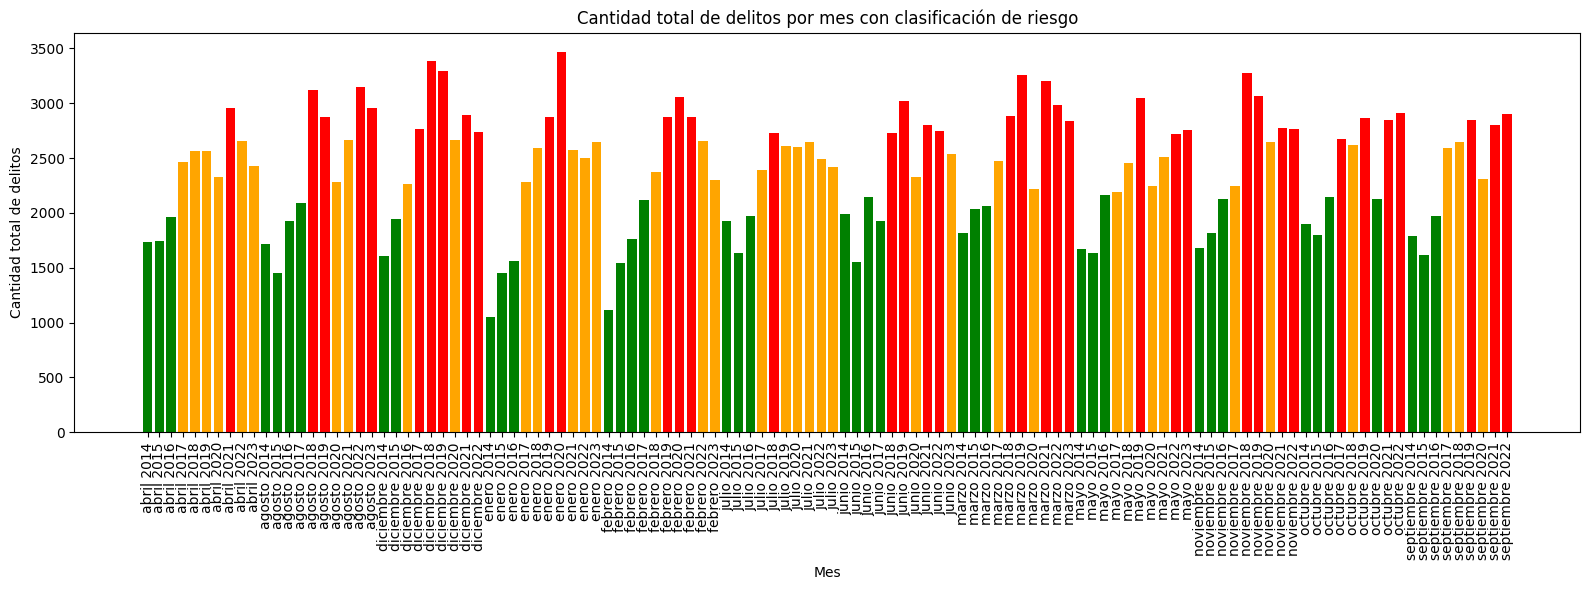

In [19]:
plt.figure(figsize=(16, 6))
plt.bar(
    unico_riesgo_por_mes['mes_anio_texto'],
    unico_riesgo_por_mes['cantidad_total'],
    color=unico_riesgo_por_mes['nivel_riesgo'].map({
        'bajo': 'green', 'medio': 'orange', 'alto': 'red'
    })
)

plt.xticks(rotation=90)
plt.title('Cantidad total de delitos por mes con clasificación de riesgo')
plt.xlabel('Mes')
plt.ylabel('Cantidad total de delitos')
plt.tight_layout()
plt.show()

- Interpretación: Como se observa, la cantidad total de delitos varía mes a mes y se identifican claramente los picos de alto riesgo (en color rojo), que se repiten especialmente en meses como diciembre y marzo. Esto permite anticipar períodos críticos en los que conviene reforzar la prevención del delito.

### Modelado 

- Agrupo el total de delitos por tipo, mes y año sumando la cantidad de cada uno

In [20]:
df_mes_delito = df_tdf_largo.groupby(['anio', 'mes', 'tipo_delito'])['cantidad'].sum().reset_index()


- Creo una tabla donde cada tipo de delito es una columna con su cantidad por mes y año

In [21]:
df_features = df_mes_delito.pivot_table(
    index=['anio', 'mes'],
    columns='tipo_delito',
    values='cantidad',
    fill_value=0
).reset_index()

- Uno con las etiquetas de riesgo mensual para preparar el dataset final

In [22]:
df_etiquetas = df_tdf_largo[['anio', 'mes', 'nivel_riesgo']].drop_duplicates()
df_modelo = df_features.merge(df_etiquetas, on=['anio', 'mes'], how='left')

- Muestro los resultados

In [23]:
print(df_modelo.head(20))


    anio  mes     Abuso sexual con acceso carnal (Violación)     Amenazas  \
0   2014    1                                              0           81   
1   2014    2                                              0            0   
2   2014    3                                              1           47   
3   2014    4                                              0           84   
4   2014    5                                              2           57   
5   2014    6                                              0           93   
6   2014    7                                              0           87   
7   2014    8                                              4           71   
8   2014    9                                              2           94   
9   2014   10                                              3          102   
10  2014   11                                              4           72   
11  2014   12                                              0           68   

### Entrenamiento del modelo (Árbol de decisiones)

- Importo las librerías

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

- Defino las variables predictoras X y la variable objetivo Y (representa el nivel de riesgo)

In [25]:
X = df_modelo.drop(columns=['nivel_riesgo', 'anio', 'mes'])
y = df_modelo['nivel_riesgo']

- Divido el dataset conjunto de entrenamiento y pruebas

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

-  Creo un árbol de decisión y lo entreno con los datos de entrenamiento

In [27]:
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

- Realizo predicciones y muestra el rendimiento del modelo 

In [28]:
y_pred = clf.predict(X_test)
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))


Reporte de Clasificación:
               precision    recall  f1-score   support

        alto       1.00      1.00      1.00         8
        bajo       1.00      1.00      1.00         8
       medio       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



- Dibujo el árbol de decisión entrenado

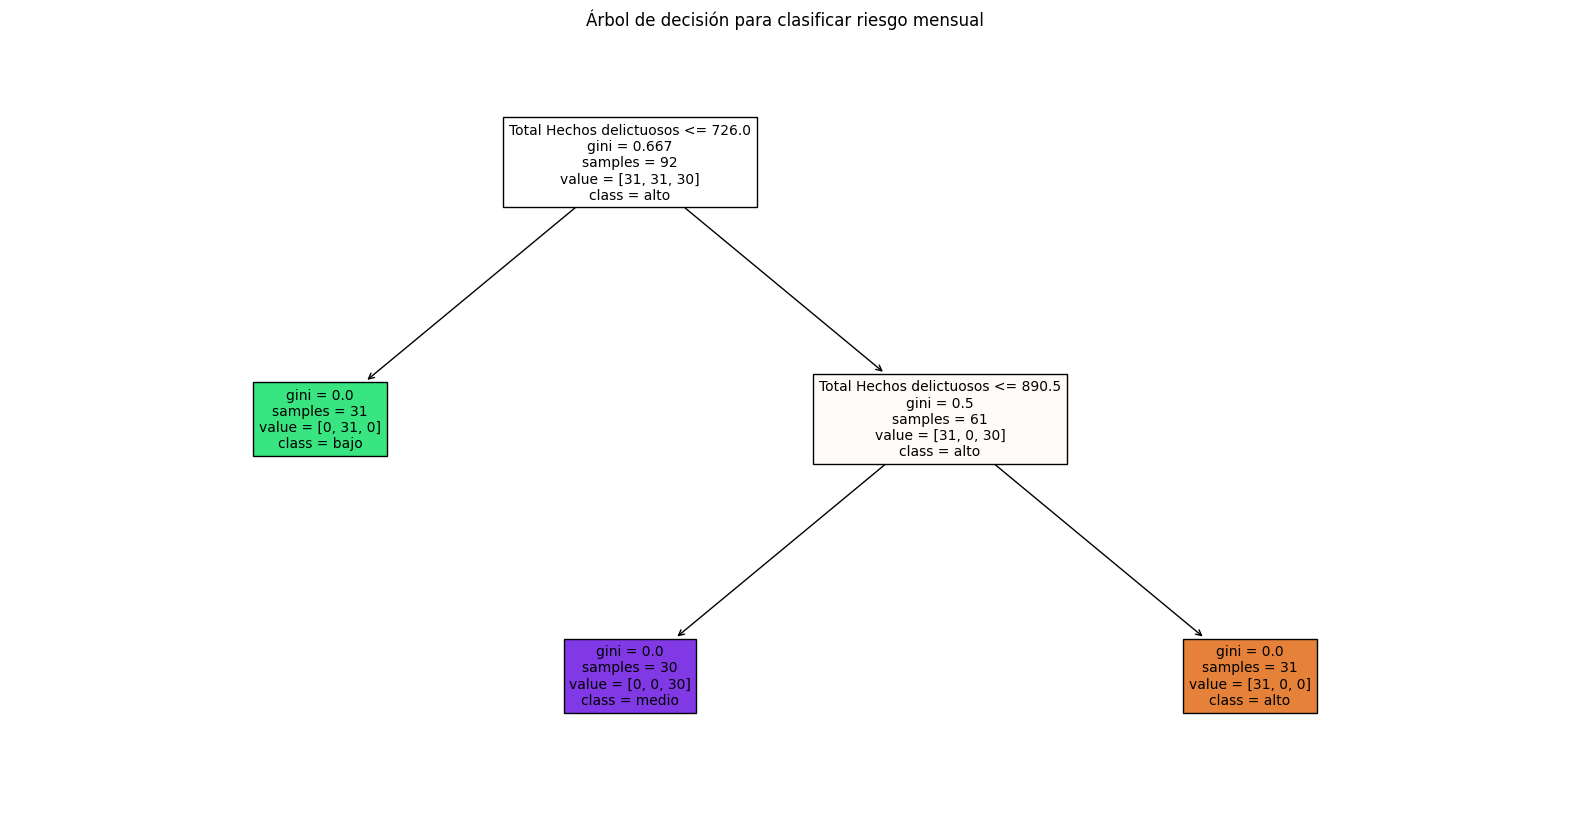

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, fontsize=10)
plt.title("Árbol de decisión para clasificar riesgo mensual")
plt.show()

- Interpretación: El modelo aprendió que si la cantidad total de delitos en un mes es menor o igual a 726, se clasifica como riesgo bajo. Si el valor está entre 726 y 890, se clasifica como riesgo medio. Y si supera los 890, se considera riesgo alto. Este árbol de decisión es fácil de interpretar y resulta muy útil para entender de forma clara cómo el modelo toma decisiones.

### Realizo el modelo con Regresión Logística para comparar


- Importo las librerías

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

- Entreno un modelo de regresión logística con 1000 iteraciones como máximo

In [31]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

c:\Users\Juana\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

- Genero predicciones del modelo de regresión logística

In [32]:
y_pred_log = log_model.predict(X_test)


- Muestro las métricas de evaluación del modelo

In [33]:
print("Regresión Logística\n")
print(classification_report(y_test, y_pred_log))

Regresión Logística

              precision    recall  f1-score   support

        alto       0.56      0.62      0.59         8
        bajo       0.83      0.62      0.71         8
       medio       0.33      0.38      0.35         8

    accuracy                           0.54        24
   macro avg       0.57      0.54      0.55        24
weighted avg       0.57      0.54      0.55        24



- Grafico la matriz de confusión

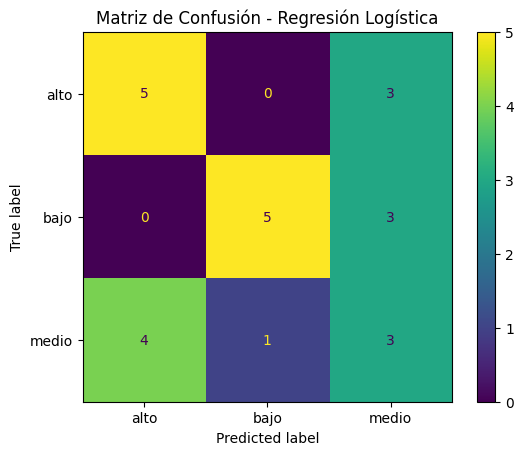

In [34]:
ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test)
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

- Interpretación: El modelo de regresión logística tuvo más dificultad para predecir los meses con riesgo medio. Se confundió varias veces con riesgo alto y bajo, como se ve en la matriz, donde hay varios errores y no todas las predicciones coinciden con los valores reales.

### Entrenamiento del modelo (Árbol de decisiones)

- Importo la librería

In [35]:
from sklearn.ensemble import RandomForestClassifier


- Entreno un modelo Random Forest con 100 árboles

In [36]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

- Genero predicciones del modelo Random Forest

In [37]:
y_pred_rf = rf_model.predict(X_test)


- Muestro métricas del modelo

In [38]:
print("Random Forest\n")
print(classification_report(y_test, y_pred_rf))

Random Forest

              precision    recall  f1-score   support

        alto       1.00      1.00      1.00         8
        bajo       1.00      0.88      0.93         8
       medio       0.89      1.00      0.94         8

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



- Grafico la matriz de confusión

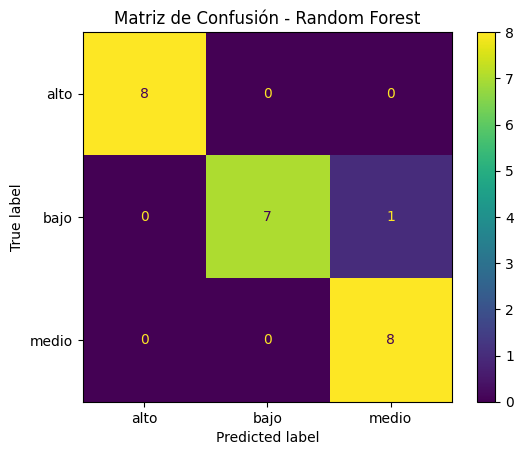

In [39]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("Matriz de Confusión - Random Forest")
plt.show()

- Interpretación: Este modelo muestra un rendimiento significativamente mejor. La mayoría de las predicciones fueron correctas y casi no se confundió entre clases. Se nota que logró identificar bien los meses de riesgo bajo, medio y alto.

# Objetivo Nº2: Clasificar cada año como "crítico" o "no crítico" según el total anual de hechos delictivos
### Creación de las etiquetas "crítico" y "no crítico".
### Modelado

- Agrupo la cantidad total de delitos por año y renombro la columna

In [40]:
df_anual = df_tdf_largo.groupby("anio")["cantidad"].sum().reset_index()
df_anual.rename(columns={"cantidad": "total_delitos"}, inplace=True)

- Creo una etiqueta para marcar los años con nivel crítico (por encima del percentil 75)

In [41]:
umbral = df_anual["total_delitos"].quantile(0.75)
df_anual["critico"] = (df_anual["total_delitos"] > umbral).astype(int)

- Reestructuro los datos para tener una fila por año y una columna por tipo de delito con la suma total

In [42]:
df_pivot = df_tdf_largo.pivot_table(
    index="anio",
    columns="tipo_delito",
    values="cantidad",
    aggfunc="sum",
    fill_value=0
).reset_index()

- Une los datos de características anuales con la etiqueta de año crítico

In [43]:
df_final = df_pivot.merge(df_anual[["anio", "critico"]], on="anio")


- Separo las variables predictoras y la variable objetivo (crítico)

In [44]:
X = df_final.drop(columns=["anio", "critico"])
y = df_final["critico"]

### Entrenamiento del modelo

- Importo las librerías

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


- Estandarizo las variables predictoras para mejorar el rendimiento

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Divido los datos en conjunto de entrenamiento y pruebas

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


- Defino un diccionario con tres modelos distintos para comparar su rendimiento.

In [48]:
modelos = {
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Regresión Logística": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

- Entreno y evalúo cada modelo mostrando precisión, métricas y la matriz de confusion


Modelo: Árbol de Decisión
Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80        53
           1       0.43      0.53      0.47        17

    accuracy                           0.71        70
   macro avg       0.63      0.65      0.64        70
weighted avg       0.74      0.71      0.72        70



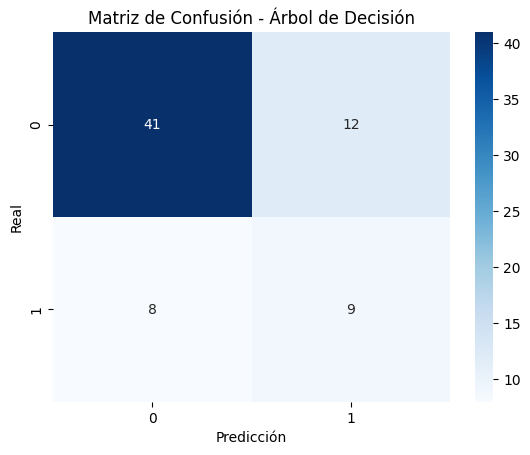


Modelo: Regresión Logística
Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        53
           1       0.00      0.00      0.00        17

    accuracy                           0.76        70
   macro avg       0.38      0.50      0.43        70
weighted avg       0.57      0.76      0.65        70



c:\Users\Juana\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Juana\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Juana\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

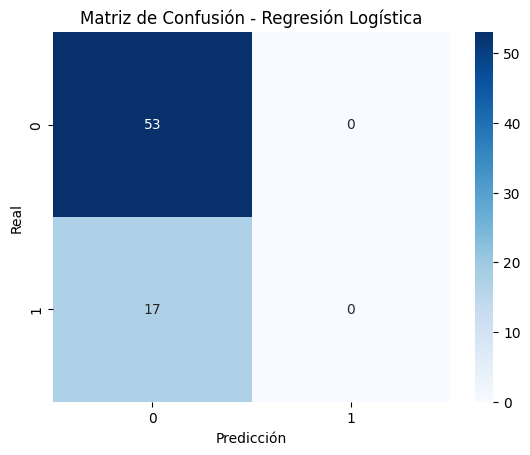


Modelo: Random Forest
Accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79        53
           1       0.31      0.29      0.30        17

    accuracy                           0.67        70
   macro avg       0.55      0.54      0.54        70
weighted avg       0.66      0.67      0.67        70



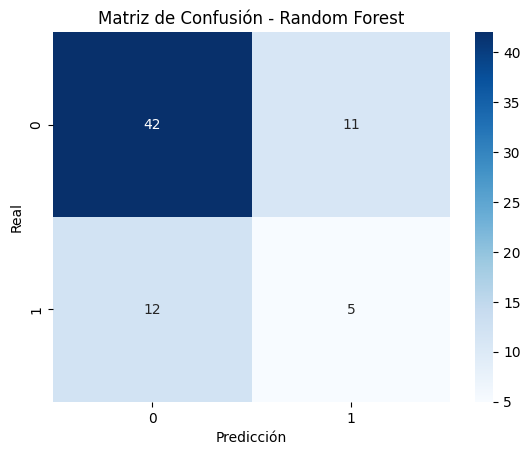

In [73]:
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print(f"\nModelo: {nombre}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    matriz = confusion_matrix(y_test, y_pred)
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

- Interpretación general: Al comparar los tres modelos, se observa que el modelo de Random Forest ofrece mejores resultados en general. Tiene menos errores y logra distinguir mejor entre los distintos niveles de riesgo o etiquetas objetivo. El árbol de decisión es más fácil de interpretar, pero menos preciso. La regresión logística tiene un rendimiento intermedio, aunque muestra algo más de confusión entre clases. Esta comparación es útil para elegir el modelo según el objetivo: si queremos entender cómo toma decisiones, usamos el árbol; si buscamos mejor rendimiento, elegimos Random Forest.

# Objetivo Nº3: Predecir cuál tipo de delito es el más probable que se repita en un determinado mes.
# Modelado


- Importo las librerías

In [50]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

- Agrupo la cantidad de delitos por tipo, año y mes para obtener el total mensual por categorías

In [51]:
df_mensual = df_tdf_largo.groupby(["anio", "mes", "tipo_delito"])["cantidad"].sum().reset_index()


- Elimina la categoría "total hechos delictuosos" para evitar sesgo en la predicción


In [52]:
df_mensual = df_mensual[df_mensual["tipo_delito"] != "Total Hechos delictuosos"]


- Extraigo el tipo de delito más frecuente por mes y lo defino como variable objetivo (delito_frecuente)

In [53]:
df_top_delito = df_mensual.loc[df_mensual.groupby(["anio", "mes"])["cantidad"].idxmax()]
df_top_delito = df_top_delito[["anio", "mes", "tipo_delito"]].rename(columns={"tipo_delito": "delito_frecuente"})


- Creo una matriz con cada tipo de delito como columna y el total mensual como valor

In [54]:
df_mensual_pivot = df_mensual.pivot_table(
    index=["anio", "mes"],
    columns="tipo_delito",
    values="cantidad",
    fill_value=0
).reset_index()

- Uno la matriz de características con el target

In [55]:
df_modelo = df_mensual_pivot.merge(df_top_delito, on=["anio", "mes"])


- Separo las variables predictoras del objetivo

In [56]:
X = df_modelo.drop(columns=["anio", "mes", "delito_frecuente"])
y = df_modelo["delito_frecuente"]

### Entrenamiento

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)


### Predicción

In [58]:
print(classification_report(y_test, y_pred))

                                   precision    recall  f1-score   support

              Contra la Propiedad       1.00      0.43      0.60         7
Otros Delitos Contra las Personas       0.88      1.00      0.93        28

                         accuracy                           0.89        35
                        macro avg       0.94      0.71      0.77        35
                     weighted avg       0.90      0.89      0.87        35



- Conclusión: El modelo logró buenos resultados en general con una precisión del 89%.

# Objetivo Nº4: Predecir combinaciones de mes y ciudad como "temporada alta" de riesgos delictivos
### Modelado 

- Importo las librerías

In [59]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

- Cargo los datasets limpios de Ushuaia y Río Grande

In [60]:
ushuaia = pd.read_csv("../data/processed/dataset_ushuaia_limpio.csv", sep=";")
riogrande = pd.read_csv("../data/processed/dataset_riogrande_limpio.csv", sep=";")

- Agrego una columna llamada ciudad a cada dataframe



In [61]:
ushuaia["ciudad"] = "Ushuaia"
riogrande["ciudad"] = "Río Grande"

- Combino los datos de ambas ciudades en un solo dataframe


In [62]:
df = pd.concat([ushuaia, riogrande], ignore_index=True)


- Transformo el dataframe a formato largo, separando mes y año como columns independientes y renombrando para estandarizar los nombres

In [63]:
df_largo = pd.melt(
    df,
    id_vars=["Tipo de Delito", "ciudad"],
    var_name="mes_anio_original",
    value_name="cantidad"
)
df_largo.rename(columns={"Tipo de Delito": "tipo_delito"}, inplace=True)
df_largo[["mes_txt", "anio"]] = df_largo["mes_anio_original"].str.split(" ", expand=True)


- Convierto los nombres de meses a números, los años a enteros y los valores de cantidad a números, reemplazando los valores nulos por 0

In [64]:
meses_a_num = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6,
    'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10,
    'noviembre': 11, 'diciembre': 12
}
df_largo["mes"] = df_largo["mes_txt"].map(meses_a_num)
df_largo["anio"] = df_largo["anio"].astype(int)
df_largo["cantidad"] = pd.to_numeric(df_largo["cantidad"], errors="coerce").fillna(0).astype(int)


- Agrupo los delitos por año, mes y ciudad, obteniendo la cantidad total mensual para cada una



In [65]:
df_mensual = df_largo.groupby(["anio", "mes", "ciudad"])["cantidad"].sum().reset_index()
df_mensual.rename(columns={"cantidad": "total_delitos"}, inplace=True)

- Creo etiqueta de temporada alta (percentil 75 por ciudad)

In [66]:
df_mensual["temporada_alta"] = 0
for ciudad in df_mensual["ciudad"].unique():
    umbral = df_mensual[df_mensual["ciudad"] == ciudad]["total_delitos"].quantile(0.75)
    df_mensual.loc[
        (df_mensual["ciudad"] == ciudad) & (df_mensual["total_delitos"] > umbral),
        "temporada_alta"
    ] = 1

- Variables predictoras y objetivo

In [67]:
X = df_mensual[["anio", "mes", "ciudad"]].copy()
y = df_mensual["temporada_alta"]

- Codifico ciudad como variable dummy

In [68]:
X = pd.get_dummies(X, columns=["ciudad"], drop_first=True)


- Divido el conjunto de datos en entrenamiento y pruebas

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Entrenamiento
- Entreno el modelo con ajustes de clases y mayor profundidad

In [70]:
modelo = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
modelo.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

- Realizo la predicción y evaluación del modelo

In [71]:
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        53
           1       0.40      0.35      0.38        17

    accuracy                           0.71        70
   macro avg       0.60      0.59      0.59        70
weighted avg       0.70      0.71      0.71        70



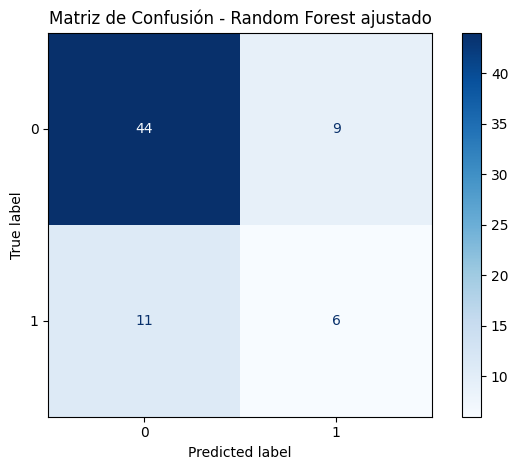

In [72]:
ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusión - Random Forest ajustado")
plt.tight_layout()
plt.show()

- Interpretabilidad: El modelo acierta la mayoría de las veces cuando no hay temporada alta, pero le cuesta más predecir bien cuándo sí la hay. Aún así, los resultados son bastante buenos y ayudan a identificar patrones por ciudad y mes

Clase 0 (no es temporada alta): El modelo lo predice bien (44 verdaderos negativos de 53)

Clase 1 (temporada alta): Tiene más dificultad (solo 6 verdaderos positivos de 17)

Por lo que se puede concluir que el modelo prefiere decir que NO es temporada alta a menos que esté muy seguro de lo contrario. Básicamente es bueno para descartar riesgo pero no tanto para anticiparlo